# Can you help reduce employee turnover?

## 📖 Background
You work for the human capital department of a large corporation. The Board is worried about the relatively high turnover, and your team must look into ways to reduce the number of employees leaving the company.

The team needs to understand better the situation, which employees are more likely to leave, and why. Once it is clear what variables impact employee churn, you can present your findings along with your ideas on how to attack the problem.

## 💾 The data
The department has assembled data on almost 10,000 employees. The team used information from exit interviews, performance reviews, and employee records.

- "department" - the department the employee belongs to.
- "promoted" - 1 if the employee was promoted in the previous 24 months, 0 otherwise.
- "review" - the composite score the employee received in their last evaluation.
- "projects" - how many projects the employee is involved in.
- "salary" - for confidentiality reasons, salary comes in three tiers: low, medium, high.
- "tenure" - how many years the employee has been at the company.
- "satisfaction" - a measure of employee satisfaction from surveys.
- "avg_hrs_month" - the average hours the employee worked in a month.
- "left" - "yes" if the employee ended up leaving, "no" otherwise.

In [1]:
!pip install -Uq seaborn
!pip install -Uq sklearn-learn
print('installed')

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dc-workspace 1.0.0 requires jupytext, which is not installed.
tensorflow 2.4.1 requires numpy~=1.19.2, but you have numpy 1.22.0 which is incompatible.
tensorflow 2.4.1 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
pythonwhat 2.23.1 requires dill~=0.2.7.1, but you have dill 0.3.3 which is incompatible.
pythonwhat 2.23.1 requires jinja2~=2.10, but you have jinja2 3.0.1 which is incompatible.
ERROR: Could not find a version that satisfies the requirement sklearn-learn (from versions: none)
ERROR: No matching distribution found for sklearn-learn
installed


In [52]:
import numpy as np
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(101)
sns.set_style('darkgrid')
sns.set_context('notebook')
matplotlib.rcParams['figure.figsize'] = (16,4)

In [53]:
df = pd.read_csv('./data/employee_churn_data.csv')
df.head()

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
0,operations,0,0.577569,3,low,5.0,0.626759,0,180.866070,no
1,operations,0,0.751900,3,medium,6.0,0.443679,0,182.708149,no
2,support,0,0.722548,3,medium,6.0,0.446823,0,184.416084,no
3,logistics,0,0.675158,4,high,8.0,0.440139,0,188.707545,no
4,sales,0,0.676203,3,high,5.0,0.577607,1,179.821083,no



## 💪 Competition challenge

Create a report that covers the following:
1. Which department has the highest employee turnover? Which one has the lowest?
2. Investigate which variables seem to be better predictors of employee departure.
3. What recommendations would you make regarding ways to reduce employee turnover?

## EDA

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9540 entries, 0 to 9539
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   department     9540 non-null   object 
 1   promoted       9540 non-null   int64  
 2   review         9540 non-null   float64
 3   projects       9540 non-null   int64  
 4   salary         9540 non-null   object 
 5   tenure         9540 non-null   float64
 6   satisfaction   9540 non-null   float64
 7   bonus          9540 non-null   int64  
 8   avg_hrs_month  9540 non-null   float64
 9   left           9540 non-null   object 
dtypes: float64(4), int64(3), object(3)
memory usage: 745.4+ KB


* we havent nulls.
* the data types seems ok.
* we have 9540 entries, 9540 workers (left and non-left).

In [55]:
df.describe().loc[['min','max','mean'],:]

,promoted,review,projects,tenure,satisfaction,bonus,avg_hrs_month
min,0.000000,0.310000,2.000000,2.000000,0.000000,0.000000,171.374060
max,1.000000,1.000000,5.000000,12.000000,1.000000,1.000000,200.861656
mean,0.030294,0.651826,3.274843,6.556184,0.504645,0.212055,184.661571


* how much left in all the company in percentages ?

In [56]:
x = round(df['left'].value_counts(normalize=True)*100)
x

no     71.0
yes    29.0
Name: left, dtype: float64

* like 29% left.
* lets check the number of employees in each department:

In [57]:
df['department'].value_counts()

sales          1883
retail         1541
operations     1522
engineering    1516
marketing       802
support         735
admin           423
finance         402
logistics       360
IT              356
Name: department, dtype: int64

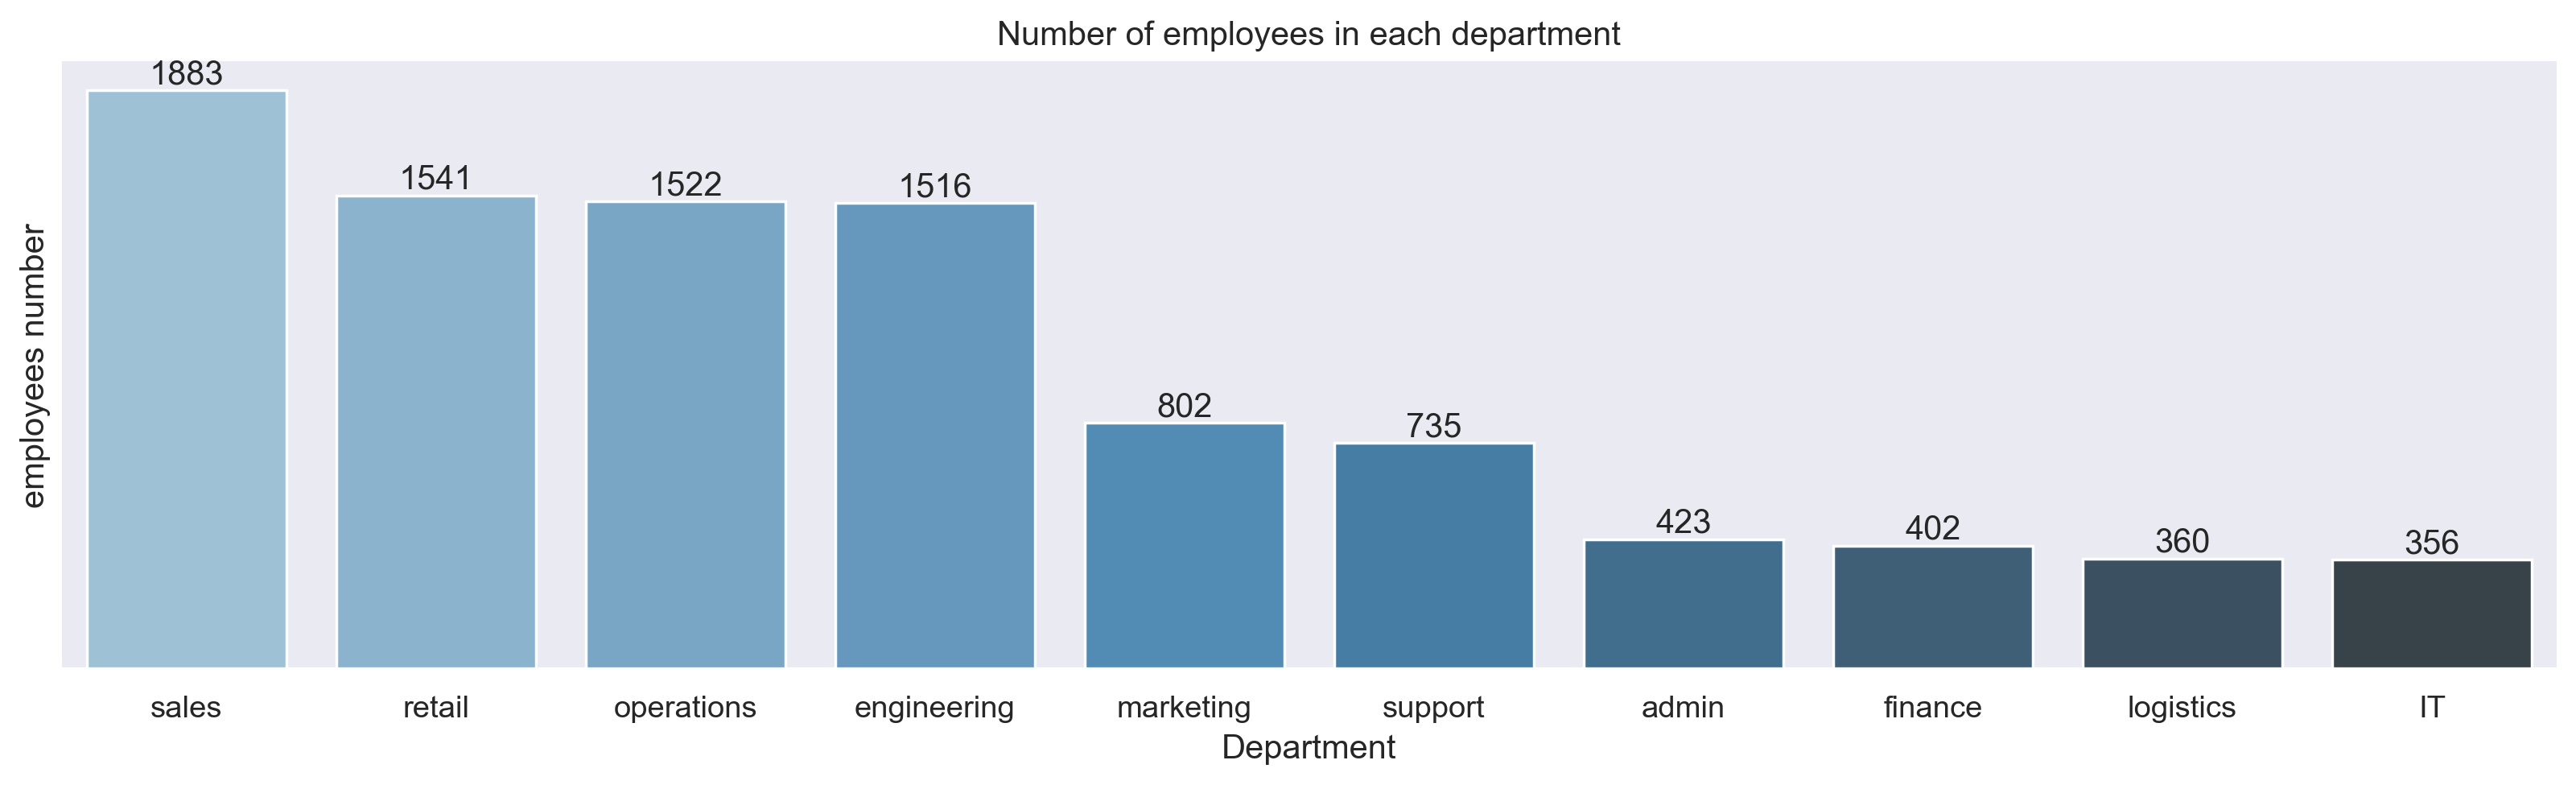

In [58]:
employees = df['department'].value_counts().reset_index()
employees.columns = ['Department','employees number']

fig, ax = plt.subplots(1,1,dpi=250)
g = sns.barplot(data= employees, x = 'Department', y='employees number', palette= 'Blues_d',ax=ax);
g.set(title='Number of employees in each department');

for bars in ax.containers:
    ax.bar_label(bars)
   
sns.despine(left=True)
g.set(yticks=[]);

### Which department has the highest employee turnover? Which one has the lowest?

* this is the departments with the highest employee turnover - by number:

In [59]:
x = pd.DataFrame(df.groupby(['department','left']).count().iloc[:,0]).reset_index()
x.columns = ['department', 'left', 'count']
numbers = x[x['left']=='yes'].sort_values(by='count',ascending=False)
numbers

,department,left,count
17,sales,yes,537
15,retail,yes,471
5,engineering,yes,437
13,operations,yes,436
11,marketing,yes,243
19,support,yes,212
3,admin,yes,119
9,logistics,yes,111
1,IT,yes,110
7,finance,yes,108


* so if we see the numbers only and not percenages, the most left at the sales department, the lowest at the finance.
* lets visualize this:

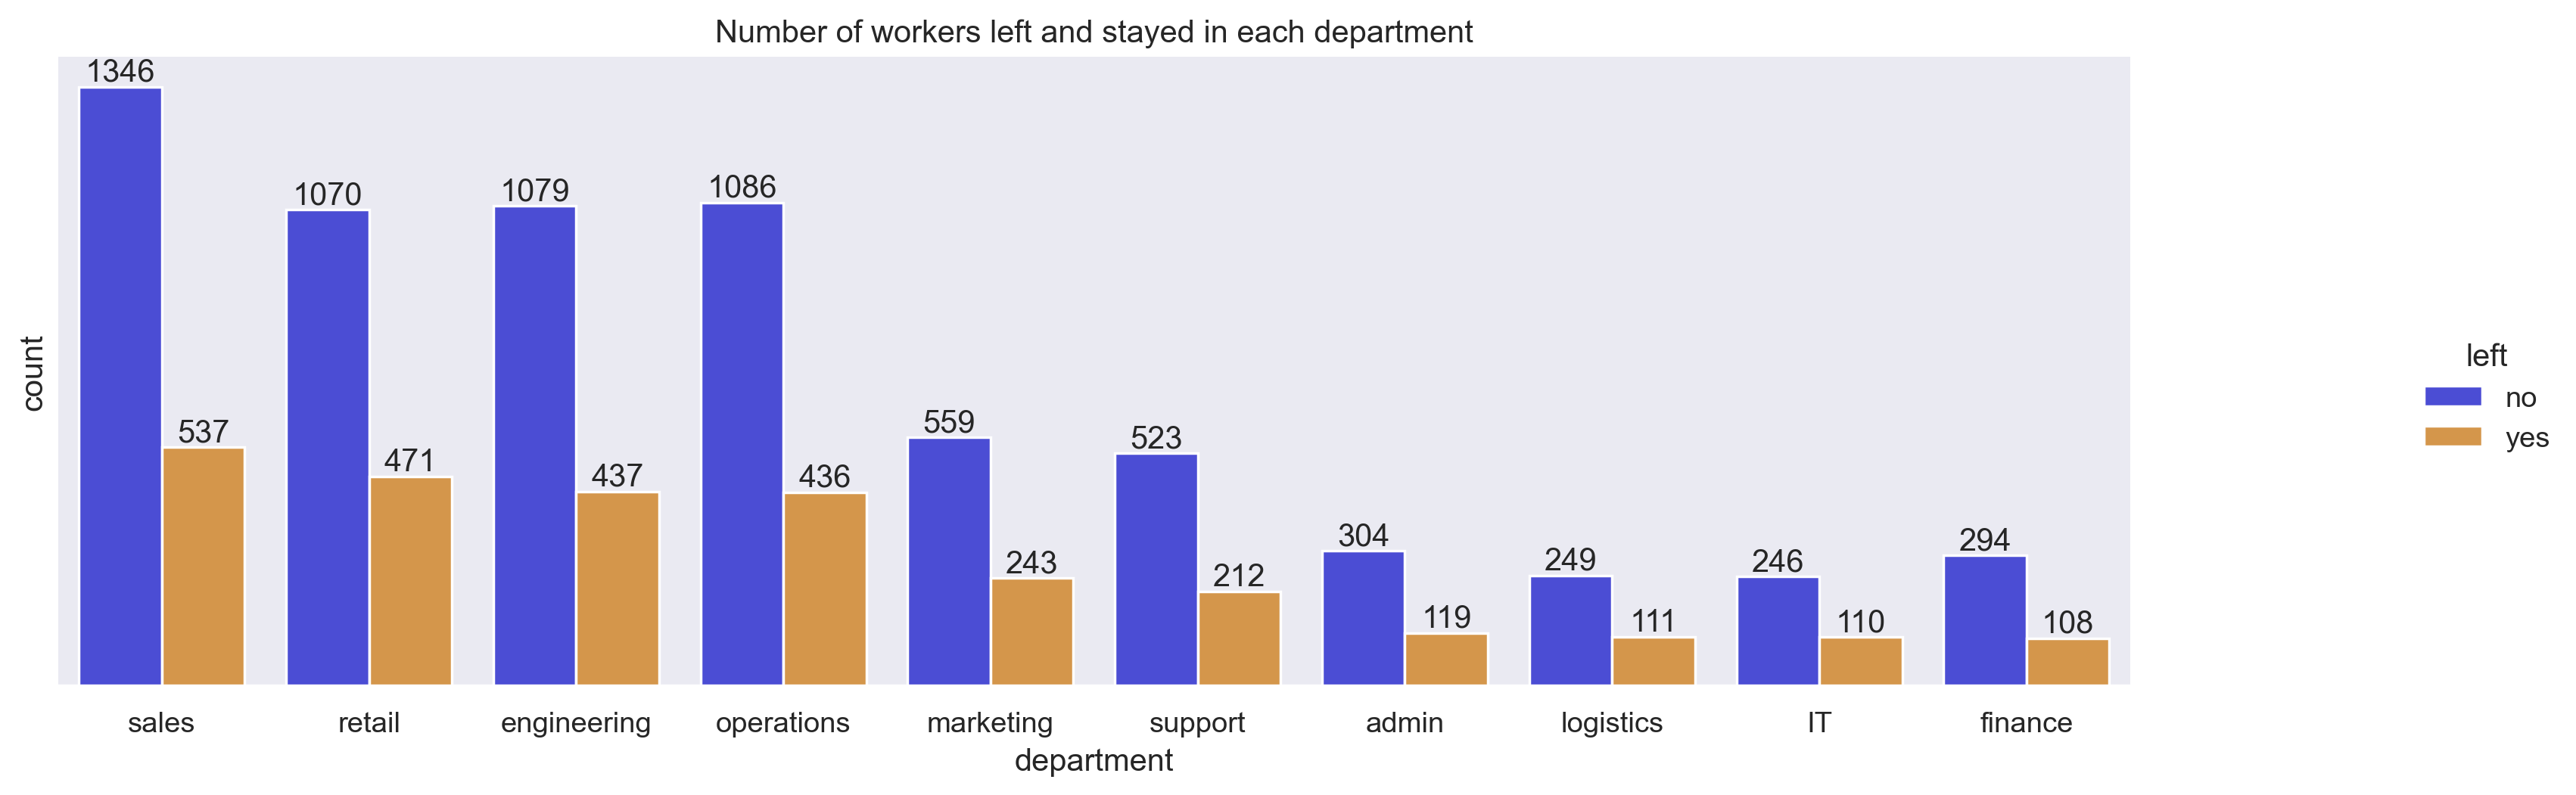

In [60]:

g = sns.catplot(data=df, kind='count', x='department',hue='left',palette=['#3437eb','#eb9834'],order=numbers['department']);
g.fig.set_figwidth(16)
g.fig.set_figheight(4)
g.fig.set_dpi(250)
g.set(title= "Number of workers left and stayed in each department");
g.despine(left=True)

for bars in g.ax.containers:
    g.ax.bar_label(bars)
 
g.set(yticks=[]); 

* but more interesting is to check it by percentages:

In [61]:
y = df['department'].value_counts()

def get_percentages(row):
    number_in_department = y[row['department']]
    return round(row['count']/number_in_department,2)*100

x["percentage_per_department"] = x.apply(get_percentages, axis=1)
percentages= x[x['left']=='yes'].sort_values(by='percentage_per_department',ascending=False)
percentages

,department,left,count,percentage_per_department
1,IT,yes,110,31.0
9,logistics,yes,111,31.0
15,retail,yes,471,31.0
11,marketing,yes,243,30.0
5,engineering,yes,437,29.0
13,operations,yes,436,29.0
17,sales,yes,537,29.0
19,support,yes,212,29.0
3,admin,yes,119,28.0
7,finance,yes,108,27.0


* so in all departments the churn rate is between 27%-31%

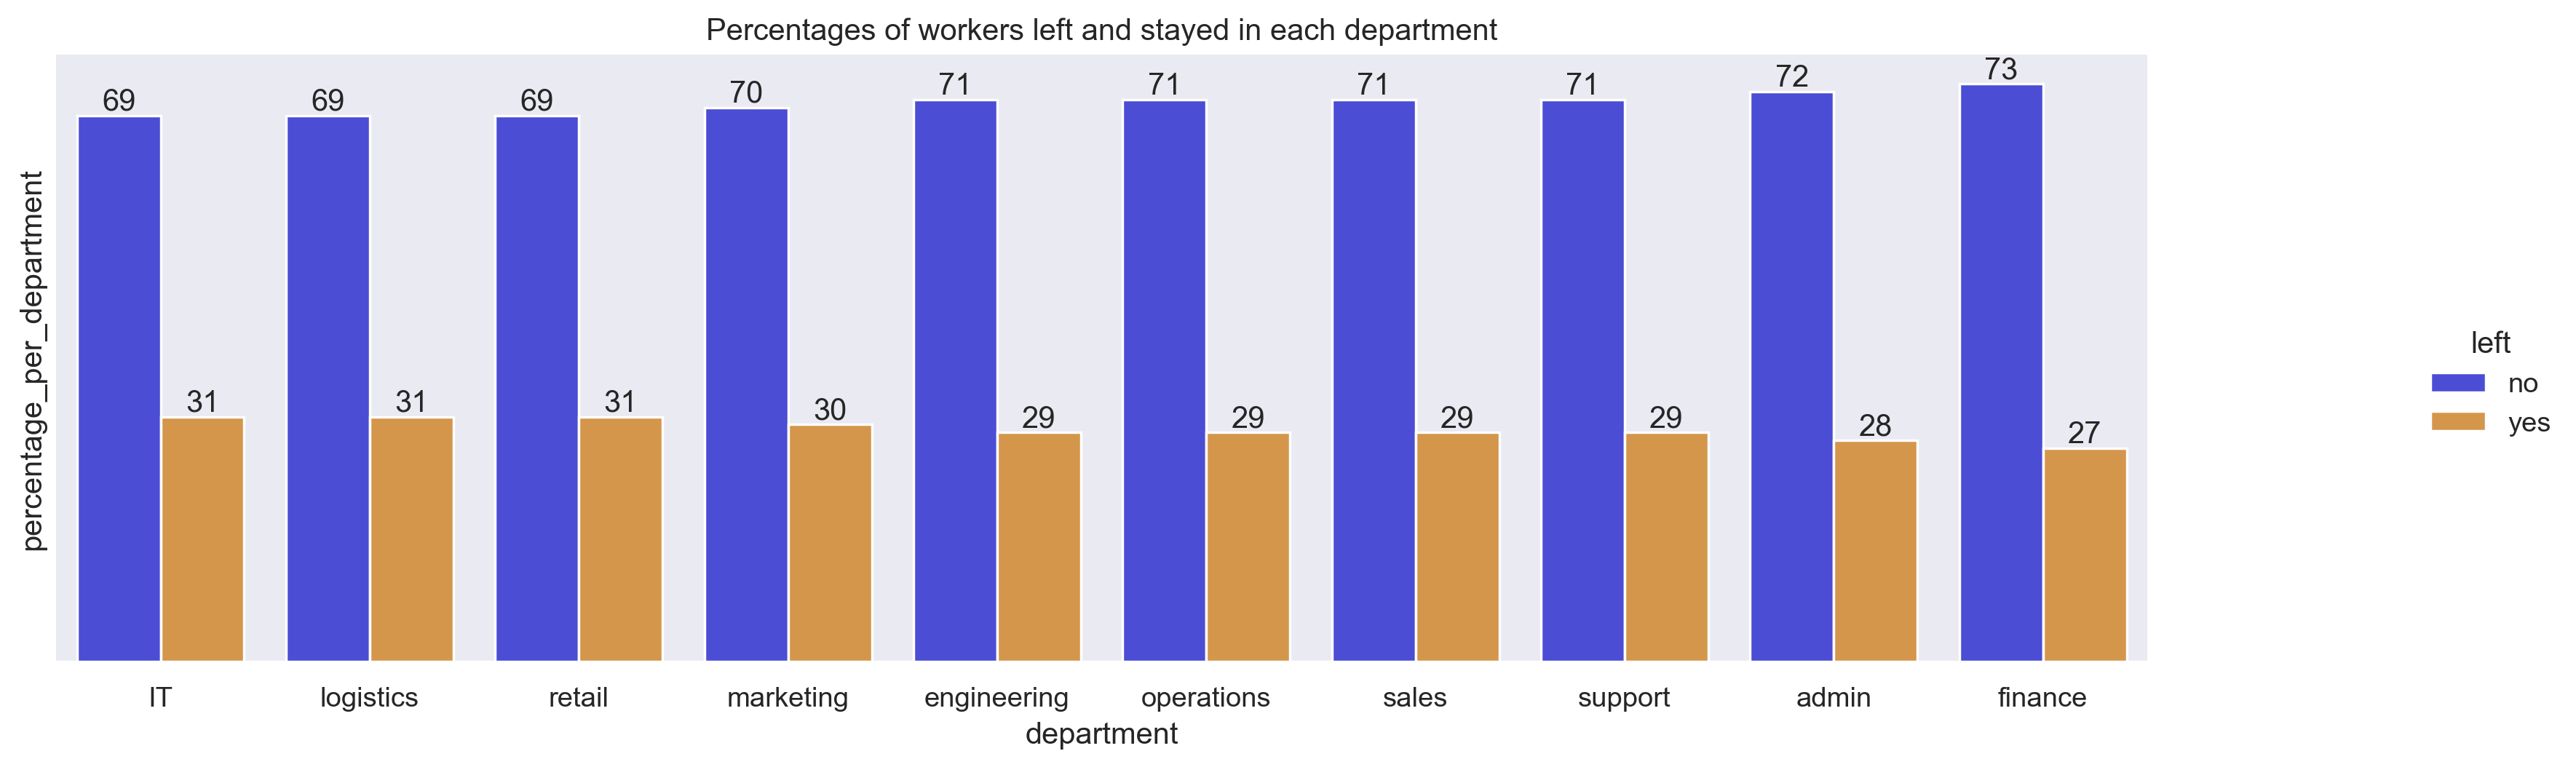

In [62]:
g = sns.catplot(data=x, kind='bar', x='department',y ='percentage_per_department' , hue='left',palette=['#3437eb','#eb9834'],
                order = percentages['department']);
g.fig.set_figwidth(16)
g.fig.set_figheight(4)
g.fig.set_dpi(250)
g.set(title= "Percentages of workers left and stayed in each department");
g.despine(left=True)

for bars in g.ax.containers:
    g.ax.bar_label(bars)
   

g.set(yticks=[]);

* the IT, logistics and retail are with the highest percentage of left employees - each of them with 31%.
* the fininace with the lowest - 27%.
* seems that the differencs between the departments, are not so big! all the departments are around 29% +-2% churn rate of employees.

## Investigate which variables seem to be better predictors of employee departure.

### is promotion, bonus, projects number, salary or tenure impact the churn rate ?
    - before it:
    - we will check how much promoted or get bonus.
    - we will turn the "left" column into numeric, it would be better for our calculations:

#### bonus

In [63]:
df['bonus'].value_counts(normalize=True)

0    0.787945
1    0.212055
Name: bonus, dtype: float64

* 21% got bonus.

In [64]:
df['left'] = df['left'].apply(lambda x: x=='yes').astype('int')

In [65]:
df.groupby('bonus')['left'].mean()

bonus
0    0.294532
1    0.281760
Name: left, dtype: float64

* we could see that there is a very small influation of the bonus on the churn rate. 

#### promotion:

In [66]:
df['promoted'].value_counts(normalize=True)

0    0.969706
1    0.030294
Name: promoted, dtype: float64

* only 3% have been promoted!

In [67]:
df.groupby('promoted')['left'].mean()

promoted
0    0.294779
1    0.197232
Name: left, dtype: float64

* we could see that there is an influation of promotion on the churn rate(20% promoted, 29% non promoted), but very small percentage have been promoted.

#### projects number:

In [68]:
df["projects"].value_counts()

3    5833
4    3058
2     578
5      71
Name: projects, dtype: int64

* most of the people are working on 3-4 projects.

In [69]:
df.groupby('projects')['left'].mean()

projects
2    0.302768
3    0.294874
4    0.284173
5    0.281690
Name: left, dtype: float64

* we could see that less projects, the higher churn rate is. but not a big differences.

#### salary

In [70]:
df["salary"].value_counts()

medium    6611
high      1548
low       1381
Name: salary, dtype: int64

* it's pretty normal - the most in the middle.

In [71]:
df.groupby('salary')['left'].mean()

salary
high      0.285530
low       0.283128
medium    0.295114
Name: left, dtype: float64

* we could see more churn rate in the medium. but small percentage.

#### tenure

In [72]:
x = df["tenure"].value_counts(normalize=True).reset_index()
x.columns = ['tenure','percentage']
x['percentage'] = round(x['percentage']*100,1)
x

,tenure,percentage
0,6.0,24.2
1,7.0,23.2
2,8.0,19.8
3,5.0,19.1
4,9.0,6.1
5,4.0,5.4
6,10.0,1.3
7,3.0,0.6
8,11.0,0.2
9,2.0,0.0


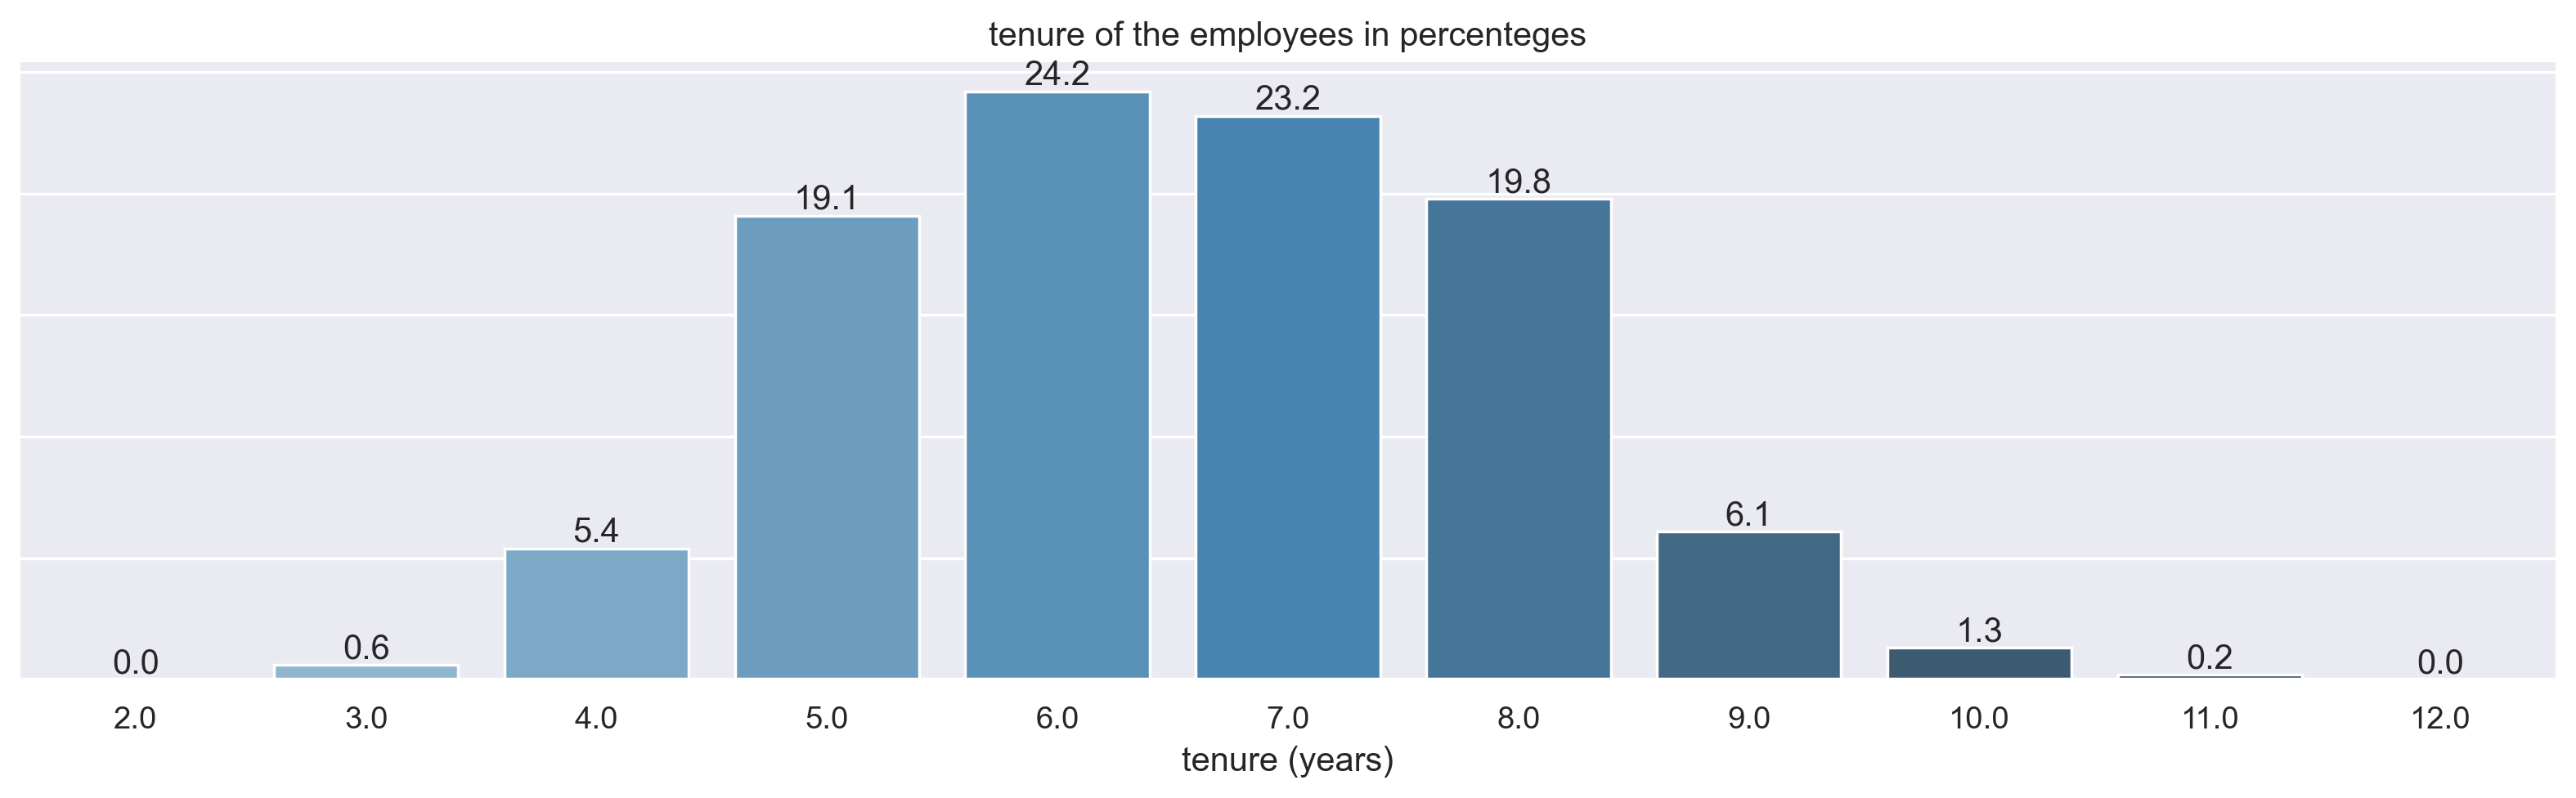

In [73]:
fig,ax = plt.subplots(1,1,dpi=250)
sns.barplot(data =x , x='tenure',y='percentage',palette= 'Blues_d',ax=ax)
ax.set(title='tenure of the employees in percenteges',ylabel='', xlabel = 'tenure (years)');

for bars in ax.containers:
    ax.bar_label(bars,fmt='%.1f')

sns.despine(left=True)
g.set(yticks=[]);
ax.set_yticklabels([]);

In [74]:
df.groupby('tenure')['left'].mean()

tenure
2.0     0.666667
3.0     0.526316
4.0     0.359073
5.0     0.234778
6.0     0.206658
7.0     0.372567
8.0     0.435911
9.0     0.024221
10.0    0.000000
11.0    0.000000
12.0    0.000000
Name: left, dtype: float64

* amazing! we see here a very clear connection between tenure and churn rate!
* the churn rate is above the mean in 2,3,4 years , then in 7,8.
* it seems like signinficant factor. 

In [75]:
x = round(df.groupby('tenure')['left'].mean()*100).reset_index()
x

,tenure,left
0,2.0,67.0
1,3.0,53.0
2,4.0,36.0
3,5.0,23.0
4,6.0,21.0
5,7.0,37.0
6,8.0,44.0
7,9.0,2.0
8,10.0,0.0
9,11.0,0.0


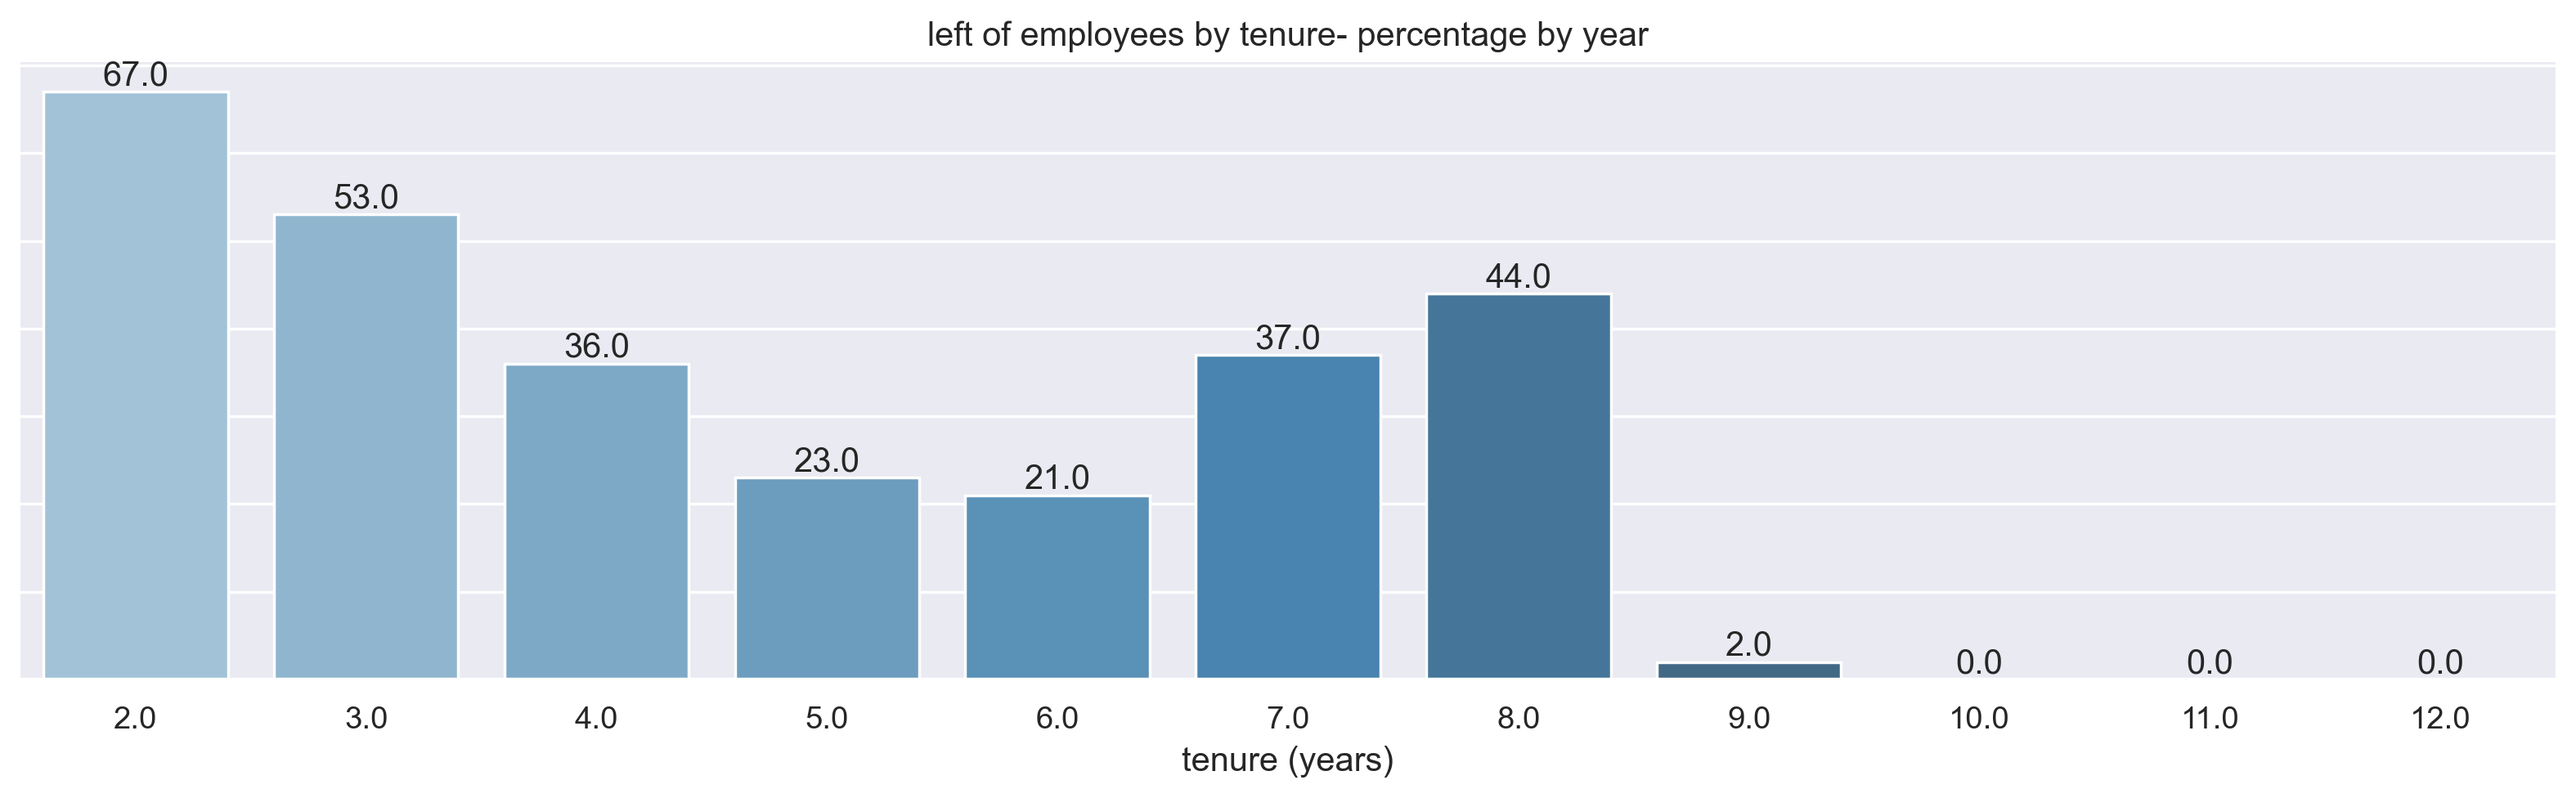

In [76]:
fig,ax = plt.subplots(1,1,dpi=250)
sns.barplot(data =x , x='tenure',y='left',palette= 'Blues_d',ax=ax)
ax.set(title='left of employees by tenure- percentage by year',ylabel='', xlabel = 'tenure (years)');

for bars in ax.containers:
    ax.bar_label(bars,fmt='%.1f')

sns.despine(left=True)
g.set(yticks=[]);
ax.set_yticklabels([]);

* we need to ask:
    * what happend in 7,8 ? why it rise again ? why it drops at 9 so dramitcly ?
* anyway we see two picks of leaving: one in the begining, and the other is about 7-8 years.

### now lets check: review, satisfaction and avg_hrs_month.

* first lets check distributions:

In [77]:
x = round(df.groupby('left')['review'].mean(),2)
x

left
0    0.64
1    0.69
Name: review, dtype: float64

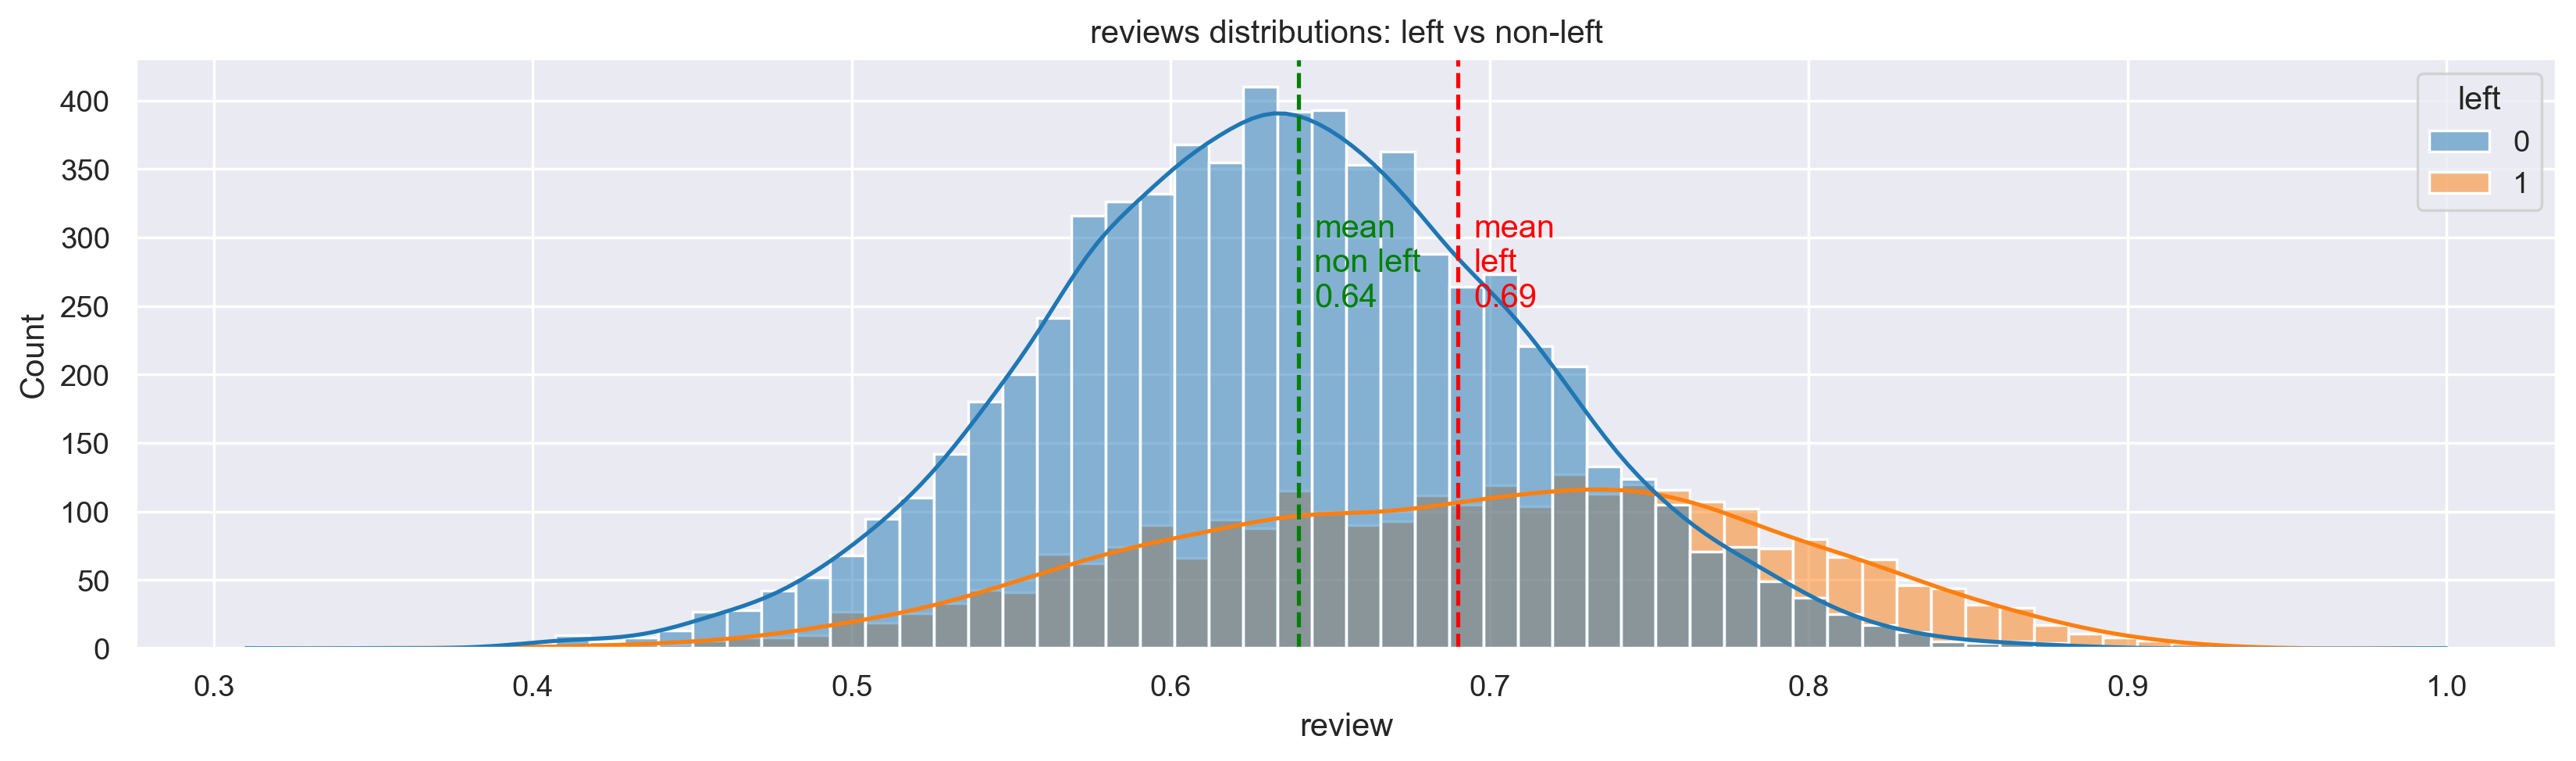

In [78]:
fig,ax = plt.subplots(1,1,dpi=250)
sns.histplot(data=df, x='review', hue='left', kde=True, ax=ax).set(title="reviews distributions: left vs non-left")
ax.axvline(x[0],color='green',ls='--');
ax.axvline(x[1],color='red', ls='--');
ax.text(x[0]+0.005,250,f"mean\nnon left\n{x[0]}", color='g');
ax.text(x[1]+0.005,250,f"mean\nleft\n{x[1]}", color='r');

In [79]:
x = round(df.groupby('left')['satisfaction'].mean(),2)
x

left
0    0.51
1    0.50
Name: satisfaction, dtype: float64

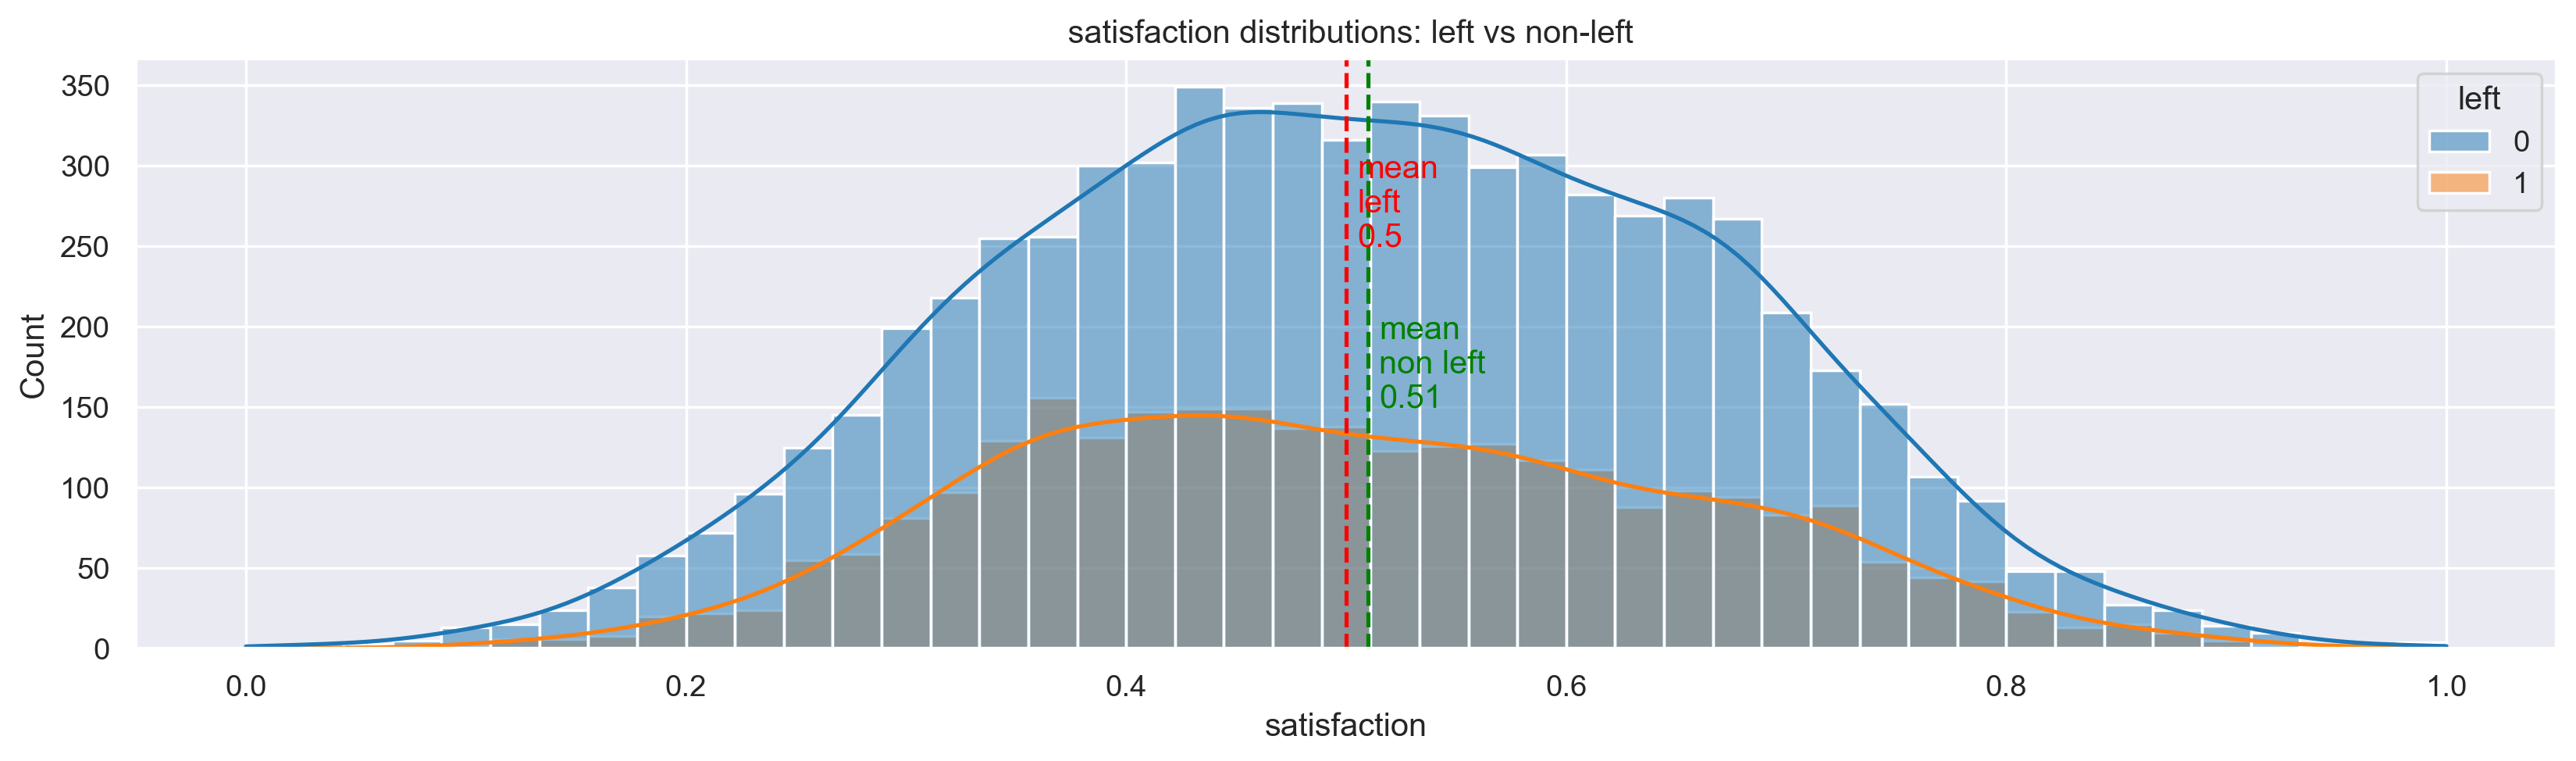

In [80]:
fig,ax = plt.subplots(1,1,dpi=250)
sns.histplot(data=df, x='satisfaction', hue='left', kde=True, ax=ax).set(title=" satisfaction distributions: left vs non-left")
ax.axvline(x[0],color='green',ls='--');
ax.axvline(x[1],color='red', ls='--');
ax.text(x[0]+0.005,150,f"mean\nnon left\n{x[0]}", color='g');
ax.text(x[1]+0.005,250,f"mean\nleft\n{x[1]}", color='r');

In [81]:
x = round(df.groupby('left')['avg_hrs_month'].mean(),2)
x

left
0    184.64
1    184.72
Name: avg_hrs_month, dtype: float64

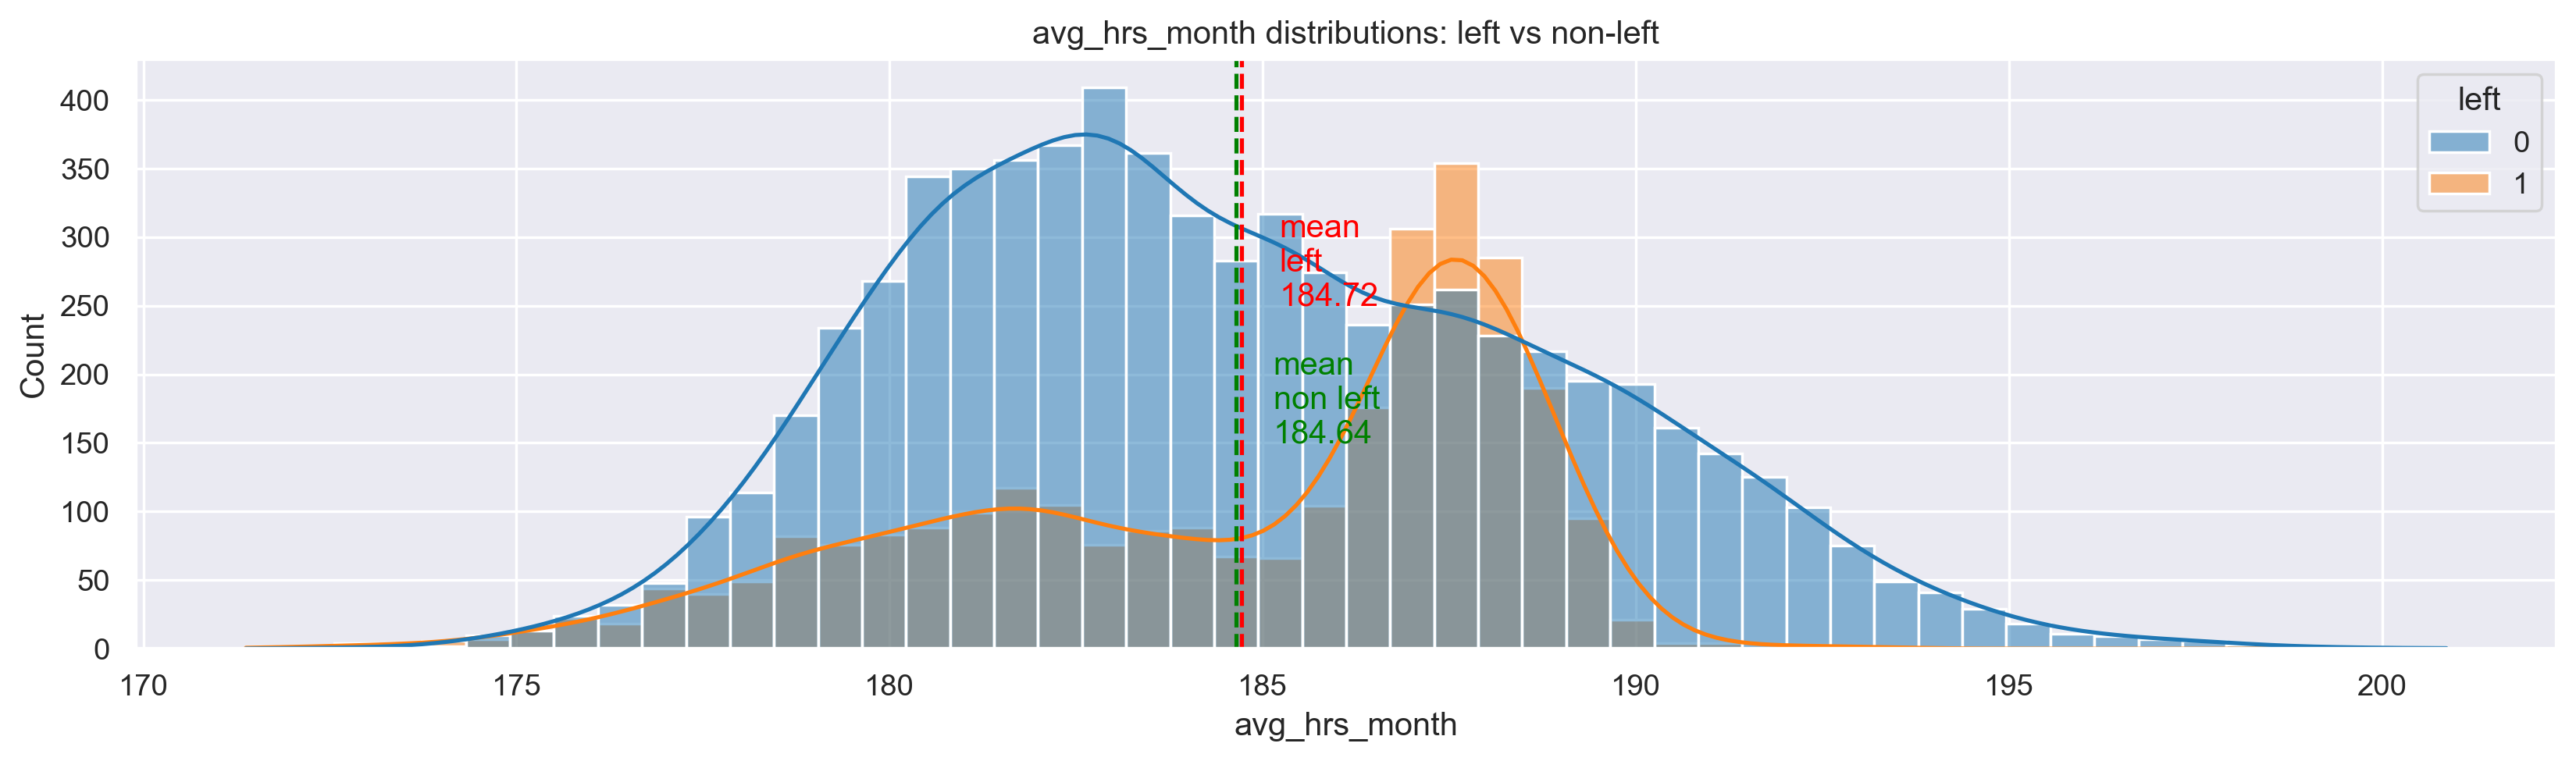

In [82]:
fig,ax = plt.subplots(1,1,dpi=250)
sns.histplot(data=df, x='avg_hrs_month', hue='left', kde=True, ax=ax).set(title="avg_hrs_month distributions: left vs non-left")
ax.axvline(x[0],color='green',ls='--');
ax.axvline(x[1],color='red', ls='--');
ax.text(x[0]+0.5,150,f"mean\nnon left\n{x[0]}", color='g');
ax.text(x[1]+0.5,250,f"mean\nleft\n{x[1]}", color='r');

* we could say that the most significant parameter we see from the distributions, is the review parameter, with a difference of 5% in the mean.
* the satisfication don't seems like a significant factor.
* the avg_hrs_month, even there isnt a big difference in the mean, there is a difference in the distribution. it could be that in the churn people there is a group which works more hours- like new employees. we should check it.

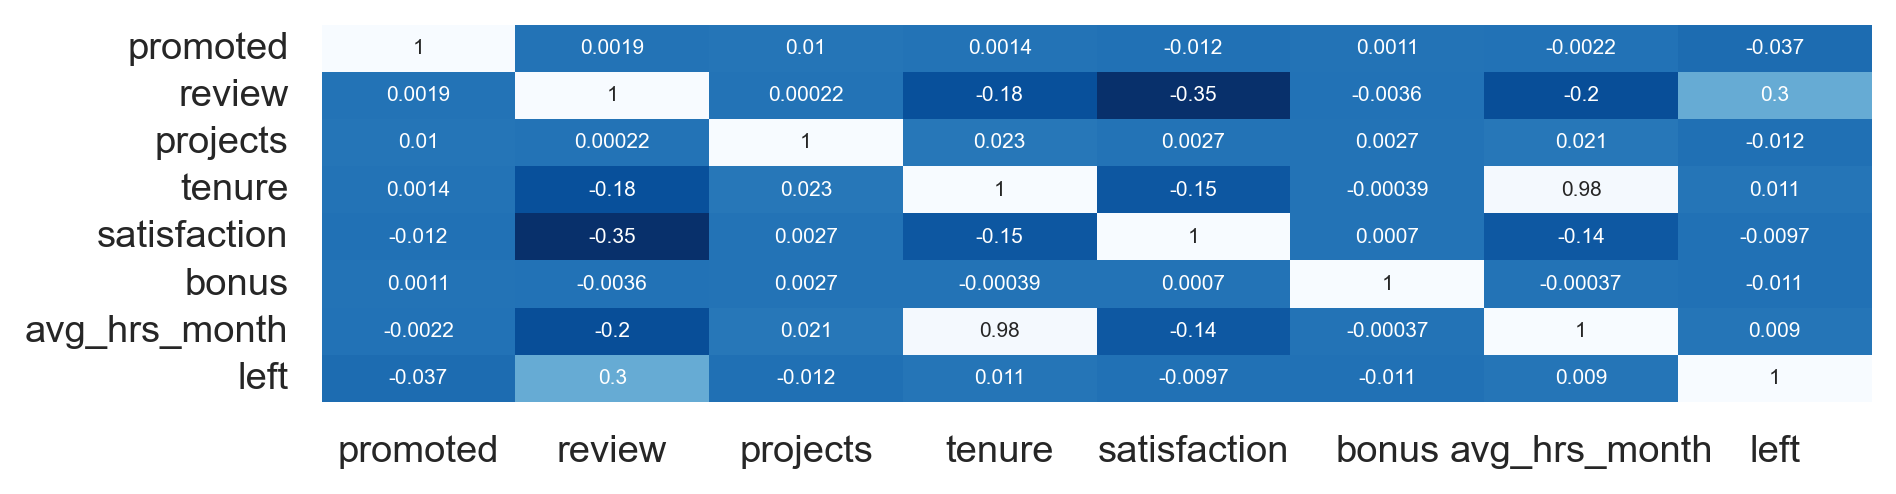

In [83]:
fig,ax = plt.subplots(1,1,dpi=250,figsize=(8,2))
sns.heatmap(df.corr(),annot=True, cbar=False, cmap = 'Blues_r',annot_kws={"size": 6});

* we see here interesting positive correlation of avg hours with tenure.
* we see that the reviews is correlated with left - with positive correlation! it's a good employees

In [84]:
df.groupby('tenure')['avg_hrs_month'].mean()

tenure
2.0     171.984493
3.0     174.651637
4.0     177.454535
5.0     180.173614
6.0     182.935656
7.0     186.163349
8.0     188.660286
9.0     191.726241
10.0    194.535087
11.0    197.484014
12.0    200.861656
Name: avg_hrs_month, dtype: float64

* i think that the "peak" we saw before in the distribution of avg_hrs_month of the people who left, is belongs to the group of 7-8 years of tenure. their mean hours too is about 187 , and we saw before that there is a pick of lefting in 187 hours. 

* so the answer to "which variables seem to be better predictors of employee departure" - first of all is the tenure, there are some clear picks which employees leaving - in the begining and in 7-8 years.
* the reviews feature too is connected positivly. some good people are tend to leave.

## Building a model.

* now we will build a model to predict who is going to leave and who isn't.
* we have 30% employees left in our dataset, so if we will do a "dumb model" which predict always "left" we will have 30% accuracy.
* we should think what is our metric. i think that we should worry about FN - people who want to leave and we dont see it, more than we should worry about FP people which stay and we think that they are leaving.
* so our metric will be "recall" because it is a metric which panish on FN.


* prepare the data

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, PrecisionRecallDisplay,ConfusionMatrixDisplay,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [86]:
df.head()

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
0,operations,0,0.577569,3,low,5.0,0.626759,0,180.866070,0
1,operations,0,0.751900,3,medium,6.0,0.443679,0,182.708149,0
2,support,0,0.722548,3,medium,6.0,0.446823,0,184.416084,0
3,logistics,0,0.675158,4,high,8.0,0.440139,0,188.707545,0
4,sales,0,0.676203,3,high,5.0,0.577607,1,179.821083,0


* we should treat some categorical variables:
    * we will use labeling for salary, because it is ordinal.
    * we will use OHE for department.

In [87]:
df['salary'] = df['salary'].map({'low':1,'medium':2,'high':3})

In [88]:
df = pd.get_dummies(df,drop_first=True)

In [89]:
df.head()

,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left,department_admin,department_engineering,department_finance,department_logistics,department_marketing,department_operations,department_retail,department_sales,department_support
0,0,0.577569,3,1,5.0,0.626759,0,180.866070,0,0,0,0,0,0,1,0,0,0
1,0,0.751900,3,2,6.0,0.443679,0,182.708149,0,0,0,0,0,0,1,0,0,0
2,0,0.722548,3,2,6.0,0.446823,0,184.416084,0,0,0,0,0,0,0,0,0,1
3,0,0.675158,4,3,8.0,0.440139,0,188.707545,0,0,0,0,1,0,0,0,0,0
4,0,0.676203,3,3,5.0,0.577607,1,179.821083,0,0,0,0,0,0,0,0,1,0


In [90]:
X = df.drop('left', axis=1)
y = df['left']

In [91]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [93]:
model = GradientBoostingClassifier()
param_grid  = {'learning_rate':[0.1,0.2],'n_estimators':[300,500,600]}
clf = GridSearchCV(scoring='recall',estimator = model, param_grid = param_grid)
clf.fit(X_train,y_train)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.2],
                         'n_estimators': [300, 500, 600]},
             scoring='recall')

In [94]:
preds = clf.predict(X_test)

In [95]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1330
           1       0.80      0.71      0.75       578

    accuracy                           0.86      1908
   macro avg       0.84      0.82      0.83      1908
weighted avg       0.86      0.86      0.86      1908



In [96]:
clf.best_params_


{'learning_rate': 0.1, 'n_estimators': 600}

In [97]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)

In [98]:
roc_auc = metrics.auc(fpr, tpr)

In [99]:
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
...                                   estimator_name='gradient boost')

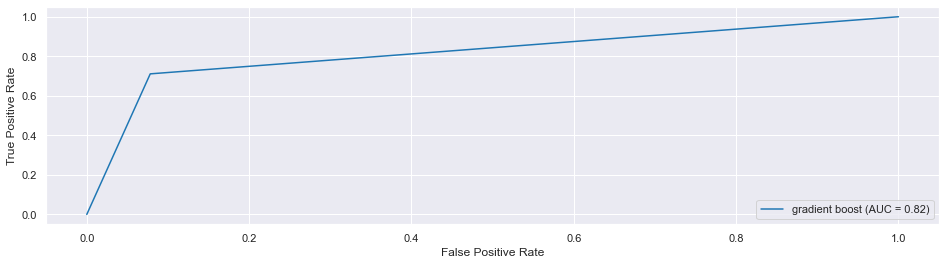

In [100]:
display.plot();

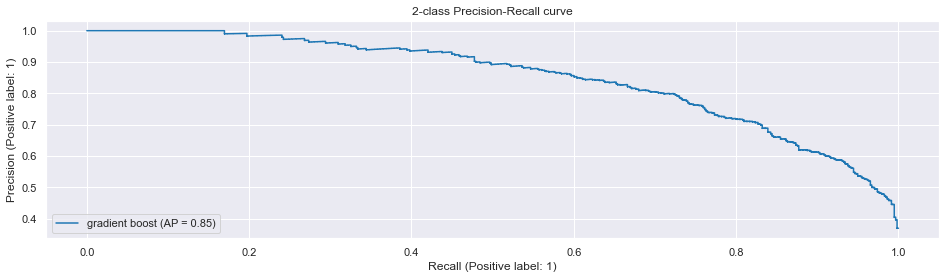

In [101]:
display = PrecisionRecallDisplay.from_estimator(
    clf, X_test, y_test, name="gradient boost"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

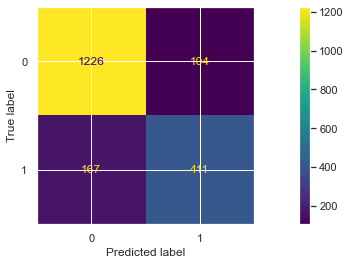

In [102]:
cm = confusion_matrix(y_test, preds, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot();

* we have a recall of 71%, and our model could predict 71% from the people who want to leave.
* we could rise up the recall by changing the threshold, but there is a trade off between the recall and precision, so we would have more false positive - people who dont want to leave and we predict them as leaving.
* that decision if rise up the threshold or not, should be done by the stake holders.

# Conclusions:
* if we are looking on leaving employees by numbers, the most employees had left from "sales" department (537) the least from finance (110)
* if we are looking on leaving employees by percentages, the percentages are pretty similar in all departments - around 29% with 2% up and down. 
* the IT, logistics and retail are with the highest percentage of left employees - each of them with 31%.
* the finnace with the lowest - 27%.
* the features which are the better predictors of employee departure are :
    1. the "tenure" - there are two pics of departure: 
        * in the begining - years 2-4.
        * employees on their 7-8 years.
    2. the "reviews". there is a small positive correlation. that means that some good employees with positive reviews are tend to leave.
* what i think about it?
    * i think that the main problem isn't the unexperienced employees which leaving in the begining, the problem is the group of left employees with 7-8 years tenture. they are experinced and have a positive reviews. so the company should do some efforts to make them stay.
    * i think that the company should focus on this group and ask them about the reasons they are leaving. 
* by the end of the project we builded a model to predict which employee would left. the model could predict correctly 71% from the leaving employees. the baseline is 30% leaving, so 71% isn't bad.
* general accuracy of the model: 86%.
* we could predict more precisly leaving employees and reduce the False Negativs, but there is a trade off that our precision score would reduce. that means that we will predict more employees who dont want to leave as employees who want too (False Positive).
* so the stake holders should decide if they want us to do so.



    


    